In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as C
import pandas as pd

In [3]:
def match(P, Po, k):
    a = (k-1)/k
    return np.sqrt((2/(k-1))*((Po/P)**a - 1))

def RatArea(M1, M2, k):
    a=(k+1)/(2*(k-1))
    b=(k-1)/2
    return (M2/M1)*(((1+b*(M1**2))/(1+b*(M2**2)))**a)

def A1A2(Po,P,k):
    a = (k-1)/k
    b = (((k+1)/2)**(1/(k-1)))*((P/Po)**(1/k))
    c = np.sqrt((k+1)/(k-1)*(1-(P/Po)**a))
    return b*c

def Cf(Pe, P0, k):
    a=(k+1)/(k-1)
    return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k)))

def thrust(Cf,At,P0):
    return At*P0*Cf*6894.757*10**(-6)

def Isp(k, Pe, Po, To, M):
    R=C.R
    a=(k-1)/k
    Isp=(1/C.g)*np.sqrt(((2*To*(R/(M*a))))*(1-(Pe/Po)**a))
    return Isp

def diametro(A):
    return np.sqrt((4*A)/C.pi)

def altura(m, mp, F, Isp, angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    
    # Fase 1
    t1=(Isp)*mp*C.g/F
    h1=1/2*ay*t1**2
    if h1>3000 :
        print("La fase 1 pasa de 3000 metros")
    
    V_y1=ay*t1
    
    # Fase 2
    t2=V_y1/C.g

    h=(ay*t1**2/2)*(1+ay/C.g)
    return h

def masa_propelente(F, Isp, m, h,angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    mp=(F/Isp)*np.sqrt(2*h/(C.g*ay)*(1/(C.g+ay)))
    return mp

def ex_vel(R, To, k):
    a = (k+1)/(k-1)
    c = np.sqrt(R*To/(k*(2/(k+1))**a))
    return c


# Al Can V2 propelente

In [4]:
P0 = 1000 #psi
Pe = 14.69 #psi=presion atmosferica
k = 1.138877 #
M = 0.03656749 # kg/mol
To = 1861.031 #1940.74 #K
theta = np.pi/2
r = 275/6 # mm/s
rho_T = 1.8892 # g/cm^3 densidad teorica 
rho_e = 1.39 # g/cm^3 densidad medida
mp=0.350 # peso del propelente utilizado en la prueba

print(rho_e/rho_T)

0.7357611687486766


P0 = 1000 #psi
Pe = 14.69 #psi=presion atmosferica
k = 1.136231 #
M = 0.03686465 # kg/mol
To = 1855.11 #1940.74 #K
theta = np.pi/2
r = 275/6 # mm/s
rho_T = 1.8805 # g/cm^3 densidad teorica 
rho_e = 1.39 # g/cm^3 densidad medida
mp=0.350 # peso del propelente utilizado en la prueba

print(rho_e/rho_T)

In [5]:
m=45 # masa del cohete sin propelente
h=3000 # metros
theta=np.pi/2 #angulo

Mt=1
Me=match(Pe,P0,k)
Dc=101.6 #mm Diametro de la camara 
Ac=C.pi*(Dc/2)**2 #mm**2 # área de la camara

## Tobera

In [6]:
# Calculos para la tobera

AtAc=1/4 #RatArea(Mt,Mc,k)
At=Ac*AtAc
AeAt = RatArea(Me, Mt, k)
Ae=At*AeAt


De=diametro(Ae)
Dt=diametro(At)
Cf=Cf(Pe,P0,k)
F=thrust(Cf,At,P0)
Isp_t = Isp(k,Pe,P0,To,M)
#Isp =Isp_t # Descomentar para utilizar el Isp teorica en los calculos
Isp = Isp_t*(0.98)*(0.95)*(0.91)*(0.99) #159 s

# Condiciones de la tobera
T_t=2*To/(k+1)
P_t=P0*(2/(k+1))**(k/(k-1))

In [7]:
#Calcular la presión de camara (Incompletos)
Ab = np.pi*(38**2)/4
Kn = Ab/(np.pi*(3/2)**2)
Po=Kn*rho_e*r*ex_vel(C.R/M, To , k)/10**(6)*145.038 # psi
print(Po, Kn, ex_vel(C.R/M, To , k), Cf, F)

1515.4038408698893 160.44444444444443 1022.1759386488307 1.634685508807481 22843.912240434816


In [8]:
# Datos de la tobera
print(Dc,Dt,De,Ac, At, Ae, Me,Mt,Cf,F, Dc/Dt, AeAt, P0, T_t, P_t)

101.6 50.8 161.28642358071414 8107.319665559963 2026.8299163899908 20430.80623675444 3.1133912301444346 1 1.634685508807481 22843.912240434816 2.0 10.080177952545705 1000 1740.1945039382817 576.6394468120438


Este analisis para obtener la masa del propelente no incluye la fuerza de fricción, por lo que se necesita resolver numéricamente las ecuaciones de movimiento como se hace posteriormente.
Para poder obtener la masa total incluyendo el propelente se puede se puede resolver con una serie geometrica de la forma
$$
\frac{M}{m}=\Sigma_{n=0}^\infty (MR)^n=\frac{1}{1-MR} ,    |MR|<1
$$
Para poder obtener un MR razonable se puede hacer un promedio de la funcion de mp/m=MR de la forma
$$
 MR=\langle \frac{m_p}{m} \rangle=\frac{1}{I_{sp}}\sqrt{\frac{2hF}{gsen\theta}} \frac{1}{b-a}\int_a^b\frac{dm}{\sqrt{Fsen\theta-mg}} 
$$
O aun mejor se puede utilizar las iteraciónes para tener un resultado mas adecuado como se muestra a continuación.

In [9]:
# Integral de mp/m
from scipy import integrate
h=3000
a, b = 40, 60
c =(1/Isp)*np.sqrt(2*h*F/(np.sin(theta)*C.g))
K = lambda m: c*(1/np.sqrt(F*np.sin(theta)-C.g*m))   

MR=1/(b-a)*(integrate.quadrature(K, a, b)[0]) # relacion de masa del propelente y el cohete

# Método iterativo 
i = 0
m_p = [0]
M_tot = [m]
error=1
while error > 10**-6:
    
    m_p.append(M_tot[i]*K(M_tot[i]))
    M_tot.append(m+m_p[i+1])
    error = M_tot[i+1]-M_tot[i]
    #print(error, M_tot[-1])
    i+=1

# Mtot = m*(1/(1-MR)) # masa total con calculo de promedio

# h1 = altura(Mtot ,Mtot-m, F, Isp, np.pi/2) #altura alcanzada
h2 = altura(M_tot[-1] ,m_p[-1], F, Isp, np.pi/2) # Altura con metodo iterativo
t = Isp*(M_tot[-1]-m)*C.g/F # tiempo de empuje


print( t, F, M_tot[-1], m_p[-1], h2, Isp) # mm

0.5862003145695194 22843.912240434816 54.55499349861612 9.554993498616122 2999.99997329416 142.91093438557274


# Trayectoria y altura


0.6969372052354665 3150.269719159425 11.359991285331922 277.17370752631507 0.012133372979594291


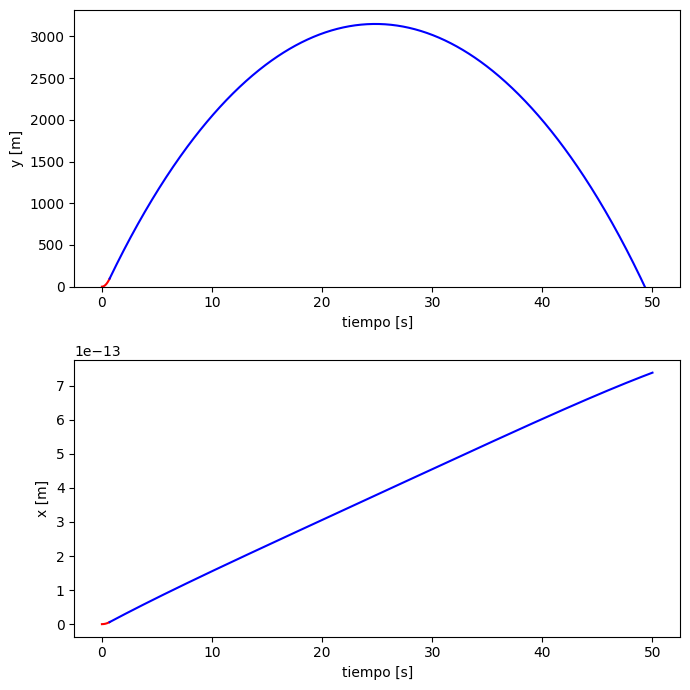

In [10]:
from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

# Sistema de ecuaciones
def f(CI, t, p):
    m, Cd, A, F, theta = p
    x, u, y, v, = CI

    dxdt = u
    dudt =  (1/m)*(F - 1/2*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt =  (1/m)*(F - 1/2*densidad_aire(y)*A*Cd*(u**2 + v**2)*np.sin(theta)) - C.g
    return [dxdt, dudt, dydt, dvdt]

h0 = 3150 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)

# Ciclo iterativo
i=0
m_p = [m*K(m)] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + m*K(m)]
h = [0]
while h[i] < h0:

    tf = Isp*(M_tot[i]-m)*C.g/F # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vx0
    t1 = np.linspace(0, tf, 1000)
    p1 = [M_tot[i], Cd , A, F, theta]
    Sol_1 = odeint(f, CI1, t1, args=(p1, ))

    # Calculos fase 2
    


    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(tf,  50, 1000)
    p2 = [m, Cd , A, 0, theta]
    Sol_2 = odeint(f, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])

    i+=1

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('tiempo [s]')
ax2.set_ylabel('x [m]')


print(tf, max(h), m_p[-1], Fd_max, Fd_max/F)

plt.tight_layout()
plt.show()

## Volumen propelente
Para obetner un buen flujo de los gases de la camara con una relación $L/D=6$
$$
\frac{A_p}{A_t}=\frac{\pi D^2(1-V_1)}{4A_t}
$$
Donde D es el diametro del propelente y V1 es la relación de propelente y volumen de la camara
$$
V_1=\frac{V_p}{V_a}
$$
Donde $V_p$ es el volumen del propelente y $V_a$ es el volumen valido de la camara. Despejando para $V_a$
$$
V_a=\frac{V_p}{1-\frac{A_p}{A_t}A_t\frac{4}{\pi D^2}}
$$

In [11]:
# Longitud de la camara 

V_e = m_p[-1]*1000/rho_e # cm^3 Volumen con densidad experiemental
V_t = m_p[-1]*1000/rho_T # cm^3 Volumen con densidad teorica
L = V_t*1000/Ac # mm  Longitud del grano solido sin huecos
# print(MR, K(50), Mtot, h1)

ApAt=1.55

Dp=np.sqrt(ApAt)*Dt #Diametro del port

Va1 = (V_e)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3
L_e = Va1*10**3/Ac # mm # Longitud del grano con densidad experimentale

Va2 = (V_t)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3
L_t = Va2*10**3/Ac # mm L_t=L_g

L_g= V_t*10**3/(Ac-ApAt*At) ## mm longitud del grano con densidad teorica

print(V_t/(Va2), L_e, L_t, L_g, Dp, Dt)

0.6125 1645.810420171253 1210.9233982839517 1210.9233982839517 63.24548995778275 50.8


## Datos obtenidos
Aquí se muestra en una tabla todos los datos importantes que se calcularon para la misión relacionados con motor (Por completar)